# Machine Learning Model Building

This notebook trains various models based on data from previous parkruns, obtained from notebooks 1-3, to produce a target time for the next parkrun.

This model uses features such as previous run times, weather conditions, and days since the last event.

The model predicts what the relative change in time should be, as an index in the form "new_time/previous_time" and converts back into a target time. This is because just training to predict a time was found to provide too slow targets for the fastest runners, and too fast targets for the slowest runners. The new model tends to provide more consistent target times.

In [3]:
import pandas as pd
import time
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt
import random 
import pickle 

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score, root_mean_squared_error, make_scorer
from sklearn.feature_selection import RFE
from sklearn.datasets import make_regression

import xgboost as xgb
from xgboost import XGBRegressor

import optuna
from optuna.visualization import plot_optimization_history, plot_param_importances

from functions.models import plot_feature_importance, plot_predicted_vs_actual

In [4]:
df = pd.read_csv('data/clean/cleaned_parkrun_no_outliers.csv')


## Process DataFrame into format for models

Does the following processing:
- Converts age groups to number
- Converts gender to 1/0 for Male/Female
- Drops null value columns
- Adds Days_since_first_parkrun column
- Removes unnecessary columns
- Creates time_change_index column as column to train for

In [7]:
def process_parkrun_data_for_models(df):
    """
    Preprocess the parkrun data from a CSV file.

    Parameters:
    - df: The cleaned dataframe

    Returns:
    - pd.DataFrame: Preprocessed DataFrame.
    """
    # Default age group mapping if none is provided

    age_group_map = {
        '18-19': 19,
        '20-24': 22,
        '25-29': 27,
        '30-34': 32,
        '35-39': 37,
        '40-44': 42,
        '45-49': 47,
        '50-54': 52,
        '55-59': 57,
        '60-64': 62,
        '65-69': 67,
        '70-74': 72
    }
    
    # Convert 'Date' column to datetime
    df['Date'] = pd.to_datetime(df['Date'])
    
    # Map 'Age_group' to numeric values
    df['Age_group_numeric'] = df['Age_group'].map(age_group_map)
    
    # Calculate the first parkrun date for each runner
    df['first_parkrun_date'] = df.groupby('Runner_id')['Date'].transform('min')
    
    # Calculate days since the first parkrun
    df['Days_since_first_parkrun'] = (df['Date'] - df['first_parkrun_date']).dt.days
    
    # Map gender to binary values
    df['Male'] = df['Gender'].apply(lambda x: 1 if x == 'Male' else 0)
    
    # Drop rows with missing values
    df = df.dropna()
    
    return df

In [8]:
df = process_parkrun_data_for_models(df)
df['time_change_index'] = df['Time_in_minutes'] / df['prev_run_time']

## Splits data for model training

In [10]:
# Drop the target and non-numeric columns
X = df[['temperature', 'windspeed', 'precipitation',
       'Appearance_Instance', 'Days_since_last_parkrun',
       'prev_run_time', 'prev_PB', 'avg_prev_run_times',
       'Age_group_numeric', 'Days_since_first_parkrun',
       'Male']]
y = df['time_change_index']


In [11]:
# Step 1: Train-test split (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# Step 2: Initialize MinMaxScaler
scaler = MinMaxScaler()

# Step 3: Normalize the training data
X_train_norm = scaler.fit_transform(X_train)

# Scales the test data using the same scaler
X_test_norm = scaler.transform(X_test)

# Save scaler as a pickle file to use
with open('models/to_use/minmax_scaler.pkl', 'wb') as file:
    pickle.dump(scaler, file)

# Convert the normalized data back to DataFrame
X_train_norm_df = pd.DataFrame(X_train_norm, columns=X.columns)
X_test_norm_df = pd.DataFrame(X_test_norm, columns=X.columns)

### Defines evaluation functions

In [13]:
def plot_feature_importance(model, feature_names, title):
    """
    Function to plot feature importance of a trained model, sorted from most to least significant.
    
    Parameters:
    model: Trained model (e.g., RandomForestRegressor)
    feature_names: List of feature names
    title: Title for the plot
    
    Returns:
    feature_importances
    """
    # Extract feature importances
    feature_importances = model.feature_importances_
    
    # Sort features by importance in descending order
    sorted_indices = np.argsort(feature_importances)[::-1]
    sorted_feature_importances = feature_importances[sorted_indices]
    sorted_feature_names = np.array(feature_names)[sorted_indices]
    
    # Plot
    plt.figure(figsize=(10, 6))
    plt.barh(sorted_feature_names, sorted_feature_importances, color='skyblue')
    plt.xscale('log')  # Use log scale for better visualization
    plt.xlabel('Feature Importance')
    plt.title(f'{title} Feature Importances (Sorted)')
    plt.gca().invert_yaxis()  # Invert y-axis to show the most important feature at the top
    plt.tight_layout()
    plt.show()
    
    return sorted_feature_importances

def plot_predicted_vs_actual(y_test, y_pred, title):
    """
    Function to plot scatter plot of predicted vs actual values.
    
    Parameters:
    y_test: Actual target values
    y_pred: Predicted target values
    
    Returns:
    None
    """
    plt.figure(figsize=(8, 6))
    plt.scatter(y_test, y_pred, color='blue', alpha=0.5)
    plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--')  # Line for perfect prediction
    
    plt.xlabel('Actual Time Change Index')
    plt.ylabel('Predicted Time Change Index')
    plt.title(f'{title} Scatter Plot: Predicted vs Actual Time Change Index')
    plt.show()

    # Calculate y_test_actual and y_pred_actual
    y_test_actual = y_test * X_test['prev_run_time'].values
    
    # Calculate y_pred_actual
    y_pred_actual = y_pred * X_test['prev_run_time'].values

    plt.figure(figsize=(8, 6))
    plt.scatter(y_test_actual, y_pred_actual, color='blue', alpha=0.5)
    plt.plot([min(y_test_actual), max(y_test_actual)], [min(y_test_actual), max(y_test_actual)], color='red', linestyle='--')  # Line for perfect prediction
    
    plt.xlabel('Actual Time (mins)')
    plt.ylabel('Predicted Time (mins)')
    plt.title(f'{title} Scatter Plot: Predicted vs Actual Run Time')
    plt.show()

def score_vs_actual(y_test, y_pred):
    """
    Function to plot scatter plot of predicted vs actual values.
    
    Parameters:
    y_test: Actual target values
    y_pred: Predicted target values
    
    Returns:
    None
    """

    # Calculate y_test_actual and y_pred_actual
    y_test_actual = y_test * X_test['prev_run_time'].values
    
    # Calculate y_pred_actual
    y_pred_actual = y_pred * X_test['prev_run_time'].values
    rmse = root_mean_squared_error(y_test_actual, y_pred_actual)
    r2 = r2_score(y_test_actual, y_pred_actual)
    
    print(f'Root Mean Squared Error: {rmse.round(3)}')
    print(f'R-squared: {r2.round(3)}')

    return y_test_actual, y_pred_actual

## Build initial models

### Random Forest:

In [16]:
# Initialize and train Random Forest model
rf = RandomForestRegressor(n_estimators=100, random_state=0)
rf.fit(X_train_norm_df, y_train)


KeyboardInterrupt: 

In [ ]:

with open('models/time_change_index/rf_model.pkl', 'wb') as f:
    pickle.dump(rf, f)

# Predict on test set
y_pred_rf = rf.predict(X_test_norm_df)

# Evaluate the model
rmse = root_mean_squared_error(y_test, y_pred_rf)
r2 = r2_score(y_test, y_pred_rf)

print(f'Root Mean Squared Error: {rmse.round(3)}')
print(f'R-squared: {r2.round(3)}')

In [ ]:
# Call functions to visualize feature importance and predicted vs actual
rf_features = plot_feature_importance(rf, X_train_norm_df.columns, 'Random Forest')
plot_predicted_vs_actual(y_test, y_pred_rf, 'Random Forest')
score_vs_actual(y_test, y_pred_rf)

### Linear Regression:

In [37]:
# Initialize and train Linear Regression model
lr = LinearRegression()
lr.fit(X_train_norm_df, y_train)

with open('models/time_change_index/linear_regression_model.pkl', 'wb') as f:
    pickle.dump(lr, f)

# Predict on test set
y_pred_lr = lr.predict(X_test_norm_df)

# Evaluate the model
rmse_lr = root_mean_squared_error(y_test, y_pred_lr)
r2_lr = r2_score(y_test, y_pred_lr)

print(f'Linear Regression - RMSE: {rmse_lr.round(3)}')
print(f'Linear Regression - R-squared: {r2_lr.round(3)}')


Linear Regression - RMSE: 0.062
Linear Regression - R-squared: 0.178


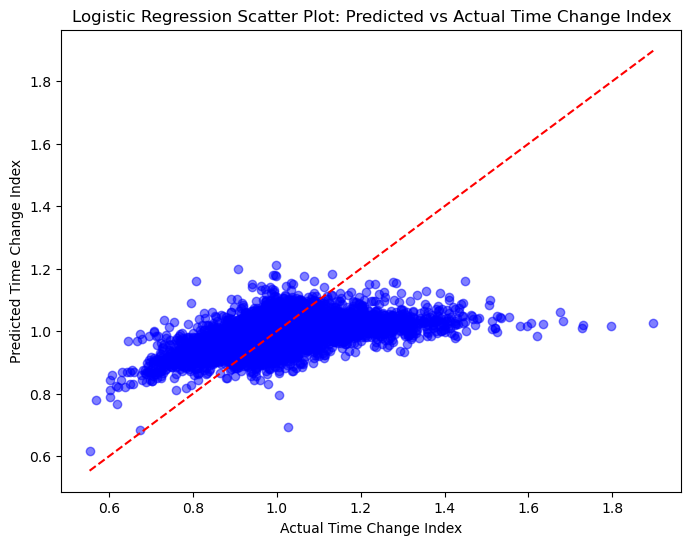

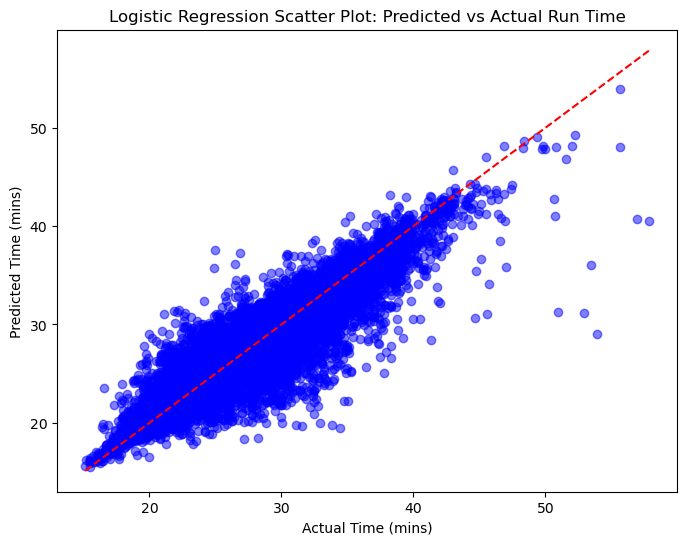

Root Mean Squared Error: 1.639
R-squared: 0.874


(66600     30.65
 30371     23.48
 87405     26.85
 114257    25.03
 13641     30.45
           ...  
 9850      23.53
 99918     30.88
 72013     33.73
 141767    21.38
 138347    33.13
 Name: time_change_index, Length: 30320, dtype: float64,
 array([31.29715408, 24.4093124 , 23.29804841, ..., 32.33741089,
        22.54905497, 33.65508052]))

In [38]:
# Visualize results
plot_predicted_vs_actual(y_test, y_pred_lr, 'Logistic Regression')
score_vs_actual(y_test, y_pred_lr)

### Gradient Boosting Regressor:

In [40]:
# Initialize and train Gradient Boosting model
gb = GradientBoostingRegressor(n_estimators=100, random_state=0)
gb.fit(X_train_norm_df, y_train)

with open('models/time_change_index/gradient_boosting_model.pkl', 'wb') as f:
    pickle.dump(gb, f)

# Predict on test set
y_pred_gb = gb.predict(X_test_norm_df)

# Evaluate the model
rmse_gb = root_mean_squared_error(y_test, y_pred_gb)
r2_gb = r2_score(y_test, y_pred_gb)

print(f'Gradient Boosting - RMSE: {rmse_gb.round(3)}')
print(f'Gradient Boosting - R-squared: {r2_gb.round(3)}')


Gradient Boosting - RMSE: 0.061
Gradient Boosting - R-squared: 0.208


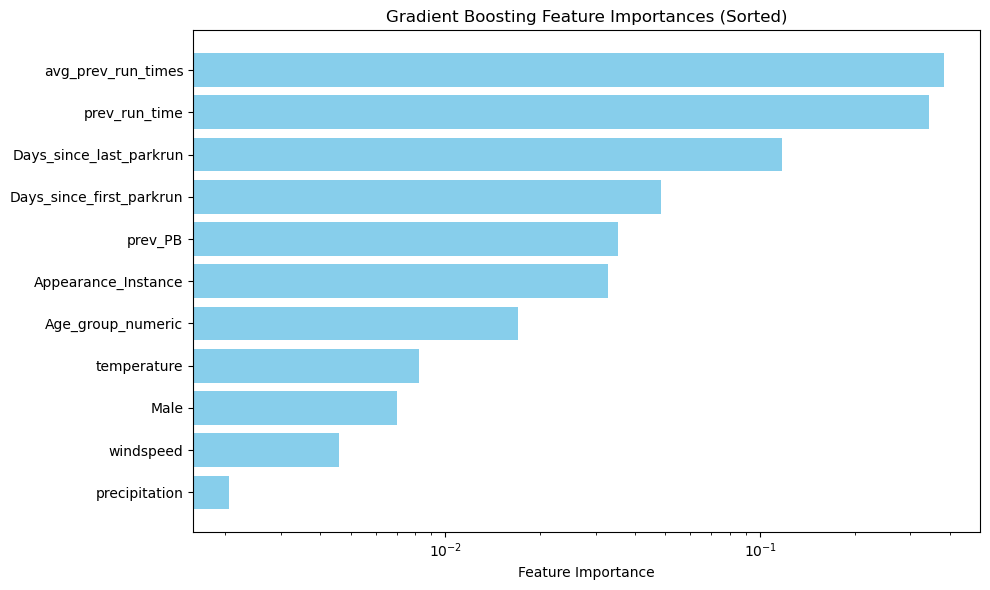

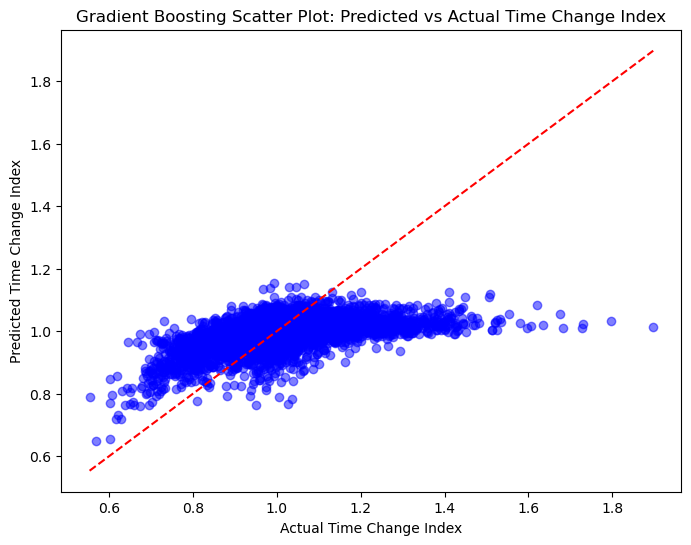

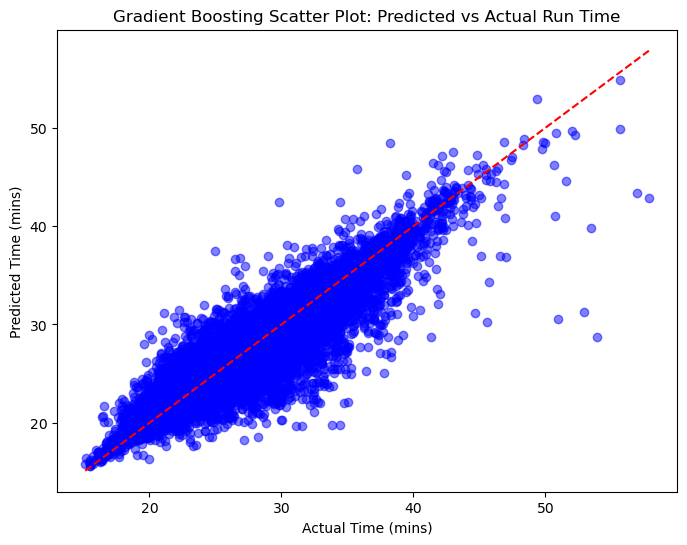

Root Mean Squared Error: 1.603
R-squared: 0.879


(66600     30.65
 30371     23.48
 87405     26.85
 114257    25.03
 13641     30.45
           ...  
 9850      23.53
 99918     30.88
 72013     33.73
 141767    21.38
 138347    33.13
 Name: time_change_index, Length: 30320, dtype: float64,
 array([31.13880455, 24.12567613, 23.21537251, ..., 32.62641217,
        22.40688448, 33.31266495]))

In [41]:
# Visualize results
gb_features = plot_feature_importance(gb, X_train_norm_df.columns, 'Gradient Boosting')
plot_predicted_vs_actual(y_test, y_pred_gb, 'Gradient Boosting')
score_vs_actual(y_test, y_pred_gb)

### XGB Regressor:

In [43]:
# Initialize and train XGBoost model
xg = xgb.XGBRegressor(n_estimators=100, random_state=0)
xg.fit(X_train_norm_df, y_train)

with open('models/time_change_index/xgb_model.pkl', 'wb') as f:
    pickle.dump(xg, f)

# Predict on test set
y_pred_xg = xg.predict(X_test_norm_df)

# Evaluate the model
rmse_xg = root_mean_squared_error(y_test, y_pred_xg)
r2_xg = r2_score(y_test, y_pred_xg)

print(f'XGBoost - RMSE: {rmse_xg.round(3)}')
print(f'XGBoost - R-squared: {r2_xg.round(3)}')


XGBoost - RMSE: 0.06
XGBoost - R-squared: 0.233


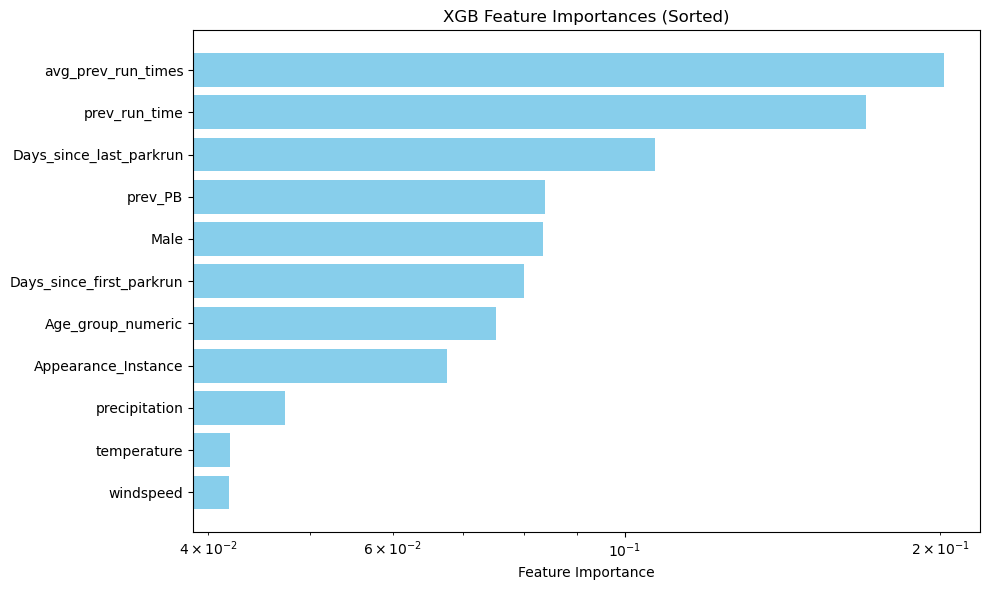

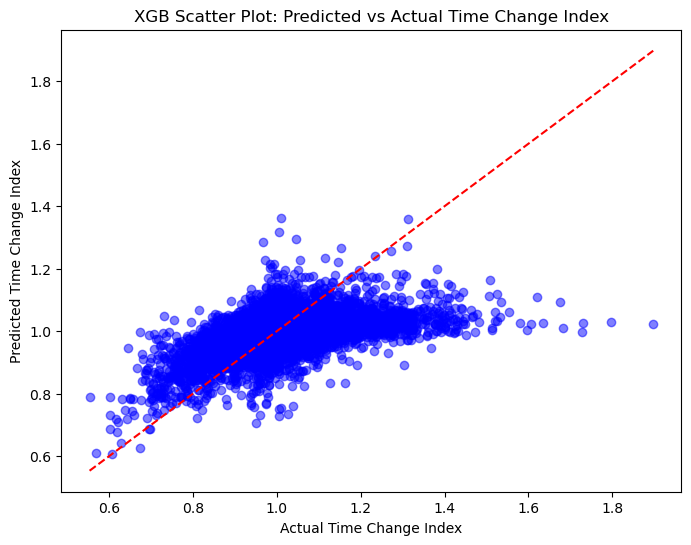

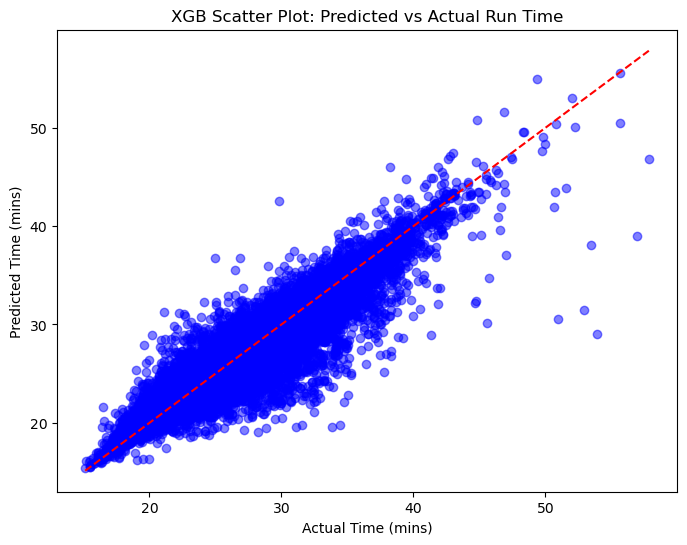

Root Mean Squared Error: 1.571
R-squared: 0.884


(66600     30.65
 30371     23.48
 87405     26.85
 114257    25.03
 13641     30.45
           ...  
 9850      23.53
 99918     30.88
 72013     33.73
 141767    21.38
 138347    33.13
 Name: time_change_index, Length: 30320, dtype: float64,
 array([31.16297841, 24.39213483, 23.62212185, ..., 32.9011972 ,
        21.97593743, 33.61966988]))

In [44]:
# Visualize results
xg_features = plot_feature_importance(xg, X_train_norm_df.columns, 'XGB')
plot_predicted_vs_actual(y_test, y_pred_xg, 'XGB')
score_vs_actual(y_test, y_pred_xg)

### K-Nearest Neighbours:

In [46]:
# Initialize and train KNN model
knn = KNeighborsRegressor(n_neighbors=7, weights='distance')
knn.fit(X_train_norm_df, y_train)

# Predict on test set
y_pred_knn = knn.predict(X_test_norm_df)

with open('models/time_change_index/knn_model.pkl', 'wb') as f:
    pickle.dump(knn, f)

# Evaluate the model
rmse_knn = root_mean_squared_error(y_test, y_pred_knn)
r2_knn = r2_score(y_test, y_pred_knn)

print(f'KNN - RMSE: {rmse_knn.round(3)}')
print(f'KNN - R-squared: {r2_knn.round(3)}')


KNN - RMSE: 0.068
KNN - R-squared: 0.016


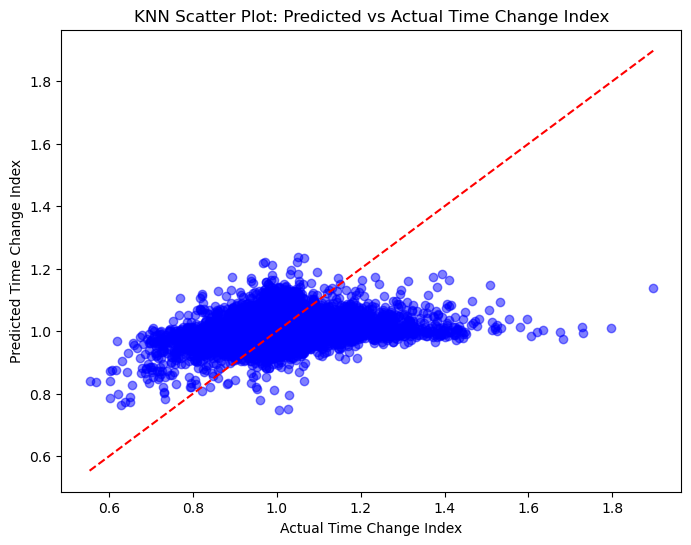

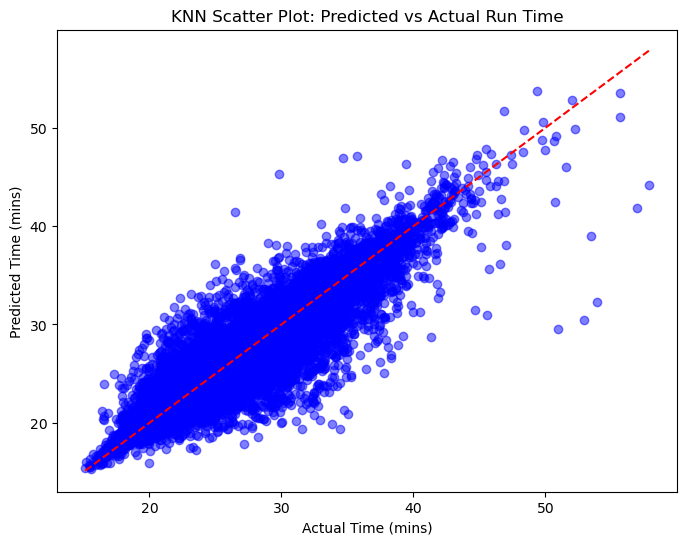

Root Mean Squared Error: 1.789
R-squared: 0.85


(66600     30.65
 30371     23.48
 87405     26.85
 114257    25.03
 13641     30.45
           ...  
 9850      23.53
 99918     30.88
 72013     33.73
 141767    21.38
 138347    33.13
 Name: time_change_index, Length: 30320, dtype: float64,
 array([30.88087107, 25.33619813, 23.20337895, ..., 33.37651532,
        22.07896165, 33.32895758]))

In [47]:
# Visualize results
plot_predicted_vs_actual(y_test, y_pred_knn, 'KNN')
score_vs_actual(y_test, y_pred_knn)

### Evaluate model performance:

In [49]:
print(f'KNN - RMSE: {rmse_knn.round(3)}')
print(f'KNN - R-squared: {r2_knn.round(3)}')
print('')
print(f'XGBoost - RMSE: {rmse_xg.round(3)}')
print(f'XGBoost - R-squared: {r2_xg.round(3)}')
print('')
print(f'Gradient Boosting - RMSE: {rmse_gb.round(3)}')
print(f'Gradient Boosting - R-squared: {r2_gb.round(3)}')
print('')
print(f'Linear Regression - RMSE: {rmse_lr.round(3)}')
print(f'Linear Regression - R-squared: {r2_lr.round(3)}')
#print('')
#print(f'Random Forest - RMSE: {rmse.round(3)}')
#print(f'Random Forest - R-squared: {r2.round(3)}')

KNN - RMSE: 0.068
KNN - R-squared: 0.016

XGBoost - RMSE: 0.06
XGBoost - R-squared: 0.233

Gradient Boosting - RMSE: 0.061
Gradient Boosting - R-squared: 0.208

Linear Regression - RMSE: 0.062
Linear Regression - R-squared: 0.178


## Optimisation

In [51]:
def objective(trial):
    # Define hyperparameter space
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 300),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'gamma': trial.suggest_float('gamma', 0, 5),
        'reg_alpha': trial.suggest_float('reg_alpha', 0, 10),
        'reg_lambda': trial.suggest_float('reg_lambda', 0, 10)
    }

    # Create and evaluate the model
    model = XGBRegressor(**params, random_state=0)
    
    # Use 'r2' directly as the scoring parameter
    scores = cross_val_score(model, X_train_norm_df, y_train, cv=5, scoring='r2')
    
    # Return the mean score
    return np.mean(scores)

In [52]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=20)  # Adjust n_trials as needed

# Best parameters and score
print("Best Parameters:", study.best_params)
print("Best R2:", study.best_value)

[I 2024-12-17 12:11:47,000] A new study created in memory with name: no-name-eedd8613-f42b-482c-b3b0-c834033d0402
[I 2024-12-17 12:11:51,750] Trial 0 finished with value: 0.08105638479464243 and parameters: {'n_estimators': 76, 'max_depth': 6, 'learning_rate': 0.20957508776392167, 'subsample': 0.8367672382170758, 'colsample_bytree': 0.7082581021205616, 'gamma': 1.847462269009395, 'reg_alpha': 1.1464849274489208, 'reg_lambda': 5.997015743360081}. Best is trial 0 with value: 0.08105638479464243.
[I 2024-12-17 12:12:01,705] Trial 1 finished with value: 0.04312767773299373 and parameters: {'n_estimators': 147, 'max_depth': 7, 'learning_rate': 0.07120364647316059, 'subsample': 0.9071023736215698, 'colsample_bytree': 0.6454294035308591, 'gamma': 4.810223121076738, 'reg_alpha': 2.995929308089017, 'reg_lambda': 5.587570160344043}. Best is trial 0 with value: 0.08105638479464243.
[I 2024-12-17 12:12:27,630] Trial 2 finished with value: 0.11139674019095373 and parameters: {'n_estimators': 278, '

Best Parameters: {'n_estimators': 249, 'max_depth': 10, 'learning_rate': 0.038681624043881285, 'subsample': 0.9845795794509689, 'colsample_bytree': 0.9975751995696668, 'gamma': 0.015577416043148662, 'reg_alpha': 7.973278308707946, 'reg_lambda': 1.4765984547565854}
Best R2: 0.2148595888493427


Training RMSE: 0.059
Training R-squared: 0.242

Test RMSE: 0.060
Test R-squared: 0.221


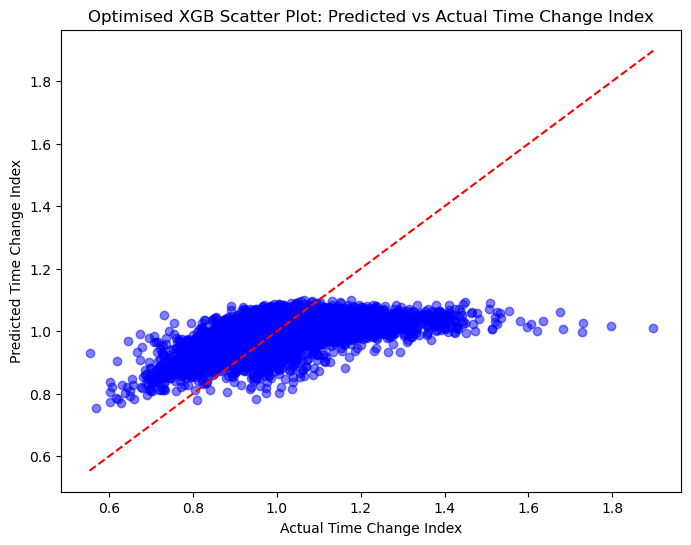

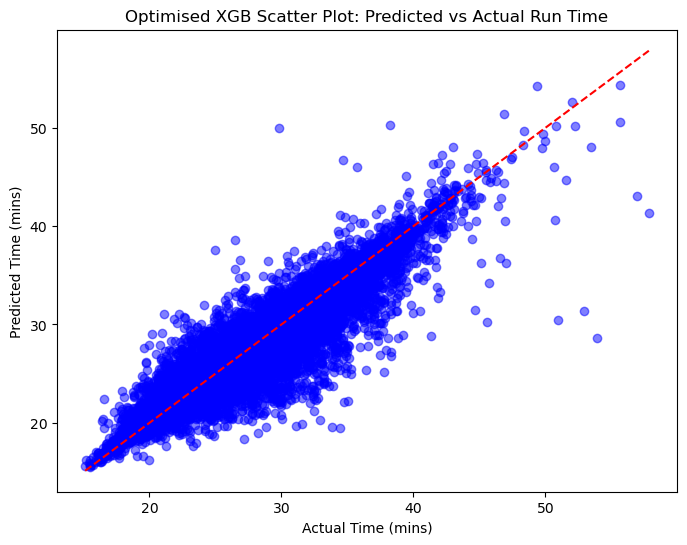

Root Mean Squared Error: 1.592
R-squared: 0.881


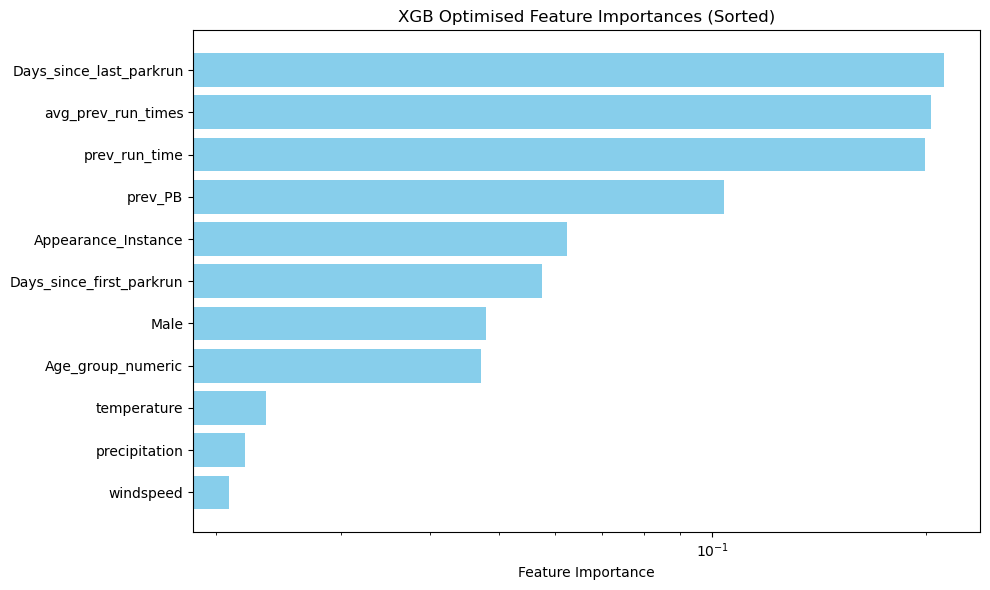

In [53]:
# Train final model with best parameters
best_params = study.best_params
best_xgb_model = XGBRegressor(**best_params, random_state=0)
best_xgb_model.fit(X_train_norm_df, y_train)

with open('models/time_change_index/optimised/xgb_opt_model.pkl', 'wb') as f:
    pickle.dump(best_xgb_model, f)

# Evaluate on test data
y_pred_opt_test = best_xgb_model.predict(X_test_norm_df)
rmse_opt_test = root_mean_squared_error(y_test, y_pred_opt_test)
r2_opt_test = r2_score(y_test, y_pred_opt_test)

# Evaluate on training data
y_pred_opt_train = best_xgb_model.predict(X_train_norm_df)
rmse_opt_train = root_mean_squared_error(y_train, y_pred_opt_train)
r2_opt_train = r2_score(y_train, y_pred_opt_train)

# Print results
print(f"Training RMSE: {rmse_opt_train:.3f}")
print(f"Training R-squared: {r2_opt_train:.3f}")
print("")
print(f"Test RMSE: {rmse_opt_test:.3f}")
print(f"Test R-squared: {r2_opt_test:.3f}")

plot_predicted_vs_actual(y_test, y_pred_opt_test, 'Optimised XGB')
score_vs_actual(y_test, y_pred_opt_test)
best_xgb_features = plot_feature_importance(best_xgb_model, X_train_norm_df.columns, 'XGB Optimised')

This is the model that we end up using

plot_optimization_history(study).show()
plot_param_importances(study).show()

## Recursive feature elimination

In [57]:
# Use RFE for feature selection
rfe = RFE(estimator=best_xgb_model, n_features_to_select=5)

# Fit the RFE model and track progress manually
num_features = X_train_norm_df.shape[1]  # Total number of features
print(f"Starting RFE with {num_features} features. Progress will be displayed...")

# Fit the RFE model and track iterations
for i in range(num_features, 0, -1):  # RFE reduces features, start from the full set
    rfe.n_features_to_select = i  # Reduce the number of features in each iteration
    rfe.fit(X_train_norm_df, y_train)
    
    # After each iteration, print the progress
    print(f"RFE iteration {num_features - i + 1}/{num_features}: {i} features remaining.")


# Get selected features and their rankings
selected_features = rfe.support_  # Boolean mask of selected features
feature_ranking = rfe.ranking_    # Feature ranking (1 means selected)

# Print results
print("Selected Features (True = Selected):", selected_features)
print("Feature Ranking:", feature_ranking)

Starting RFE with 11 features. Progress will be displayed...
RFE iteration 1/11: 11 features remaining.
RFE iteration 2/11: 10 features remaining.
RFE iteration 3/11: 9 features remaining.
RFE iteration 4/11: 8 features remaining.
RFE iteration 5/11: 7 features remaining.
RFE iteration 6/11: 6 features remaining.
RFE iteration 7/11: 5 features remaining.
RFE iteration 8/11: 4 features remaining.
RFE iteration 9/11: 3 features remaining.
RFE iteration 10/11: 2 features remaining.
RFE iteration 11/11: 1 features remaining.
Selected Features (True = Selected): [False False False False False  True False False False False False]
Feature Ranking: [10 11  9  5  3  1  4  2  7  6  8]


In [58]:
ranked_columns = [(col, rank) for col, rank in zip(X_train_norm_df.columns, feature_ranking)]

ranked_columns = sorted(ranked_columns, key=lambda x: x[1])
ranked_columns

[('prev_run_time', 1),
 ('avg_prev_run_times', 2),
 ('Days_since_last_parkrun', 3),
 ('prev_PB', 4),
 ('Appearance_Instance', 5),
 ('Days_since_first_parkrun', 6),
 ('Age_group_numeric', 7),
 ('Male', 8),
 ('precipitation', 9),
 ('temperature', 10),
 ('windspeed', 11)]

### Test and train models with different numbers of features

In [60]:
def optimize_and_train_model(sorted_features, X_train_norm_df, X_test_norm_df, y_train, y_test, model_save_path, top_n=6, n_trials=50):
    """
    Function to optimize an XGBoost model using Optuna, train it with the best parameters, 
    and evaluate it on training and test sets.

    Parameters:
    sorted_features: List of tuples containing feature names and their scores, sorted by importance.
    X_train_norm_df: DataFrame containing normalized training features.
    X_test_norm_df: DataFrame containing normalized test features.
    y_train: Training target variable.
    y_test: Test target variable.
    top_n: Number of top features to use for optimization. Default is 6.
    n_trials: Number of trials for Optuna optimization. Default is 50.
    model_save_path: Path to save the trained model.

    Returns:
    study: Optuna study object containing optimization results.
    best_model: Trained XGBoost model with the best parameters.
    """
    # Select top N features
    top_n_cols = [feature[0] for feature in sorted_features[:top_n]]
    filt_X_train_norm_df = X_train_norm_df[top_n_cols]
    filt_X_test_norm_df = X_test_norm_df[top_n_cols]

    # Define the objective function for Optuna
    def objective(trial):
        # Define hyperparameter space
        params = {
            'n_estimators': trial.suggest_int('n_estimators', 50, 300),
            'max_depth': trial.suggest_int('max_depth', 3, 10),
            'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
            'subsample': trial.suggest_float('subsample', 0.6, 1.0),
            'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
            'gamma': trial.suggest_float('gamma', 0, 5),
            'reg_alpha': trial.suggest_float('reg_alpha', 0, 10),
            'reg_lambda': trial.suggest_float('reg_lambda', 0, 10),
        }

        # Create and evaluate the model
        model = XGBRegressor(**params, random_state=0)
        scores = cross_val_score(
            model, filt_X_train_norm_df, y_train, 
            cv=5, scoring=make_scorer(root_mean_squared_error, greater_is_better=False)
        )
        return np.mean(scores)

    # Run the Optuna study
    study = optuna.create_study(direction='maximize')
    study.optimize(objective, n_trials=n_trials)

    # Train the final model with the best parameters
    best_params = study.best_params
    best_model = XGBRegressor(**best_params, random_state=0)
    best_model.fit(filt_X_train_norm_df, y_train)

    # Save the trained model
    with open(model_save_path, 'wb') as f:
        pickle.dump(best_model, f)

    # Evaluate on test data
    y_pred_test = best_model.predict(filt_X_test_norm_df)
    rmse_test = np.sqrt(np.mean((y_test - y_pred_test) ** 2))  # Root Mean Squared Error
    r2_test = r2_score(y_test, y_pred_test)

    # Evaluate on training data
    y_pred_train = best_model.predict(filt_X_train_norm_df)
    rmse_train = np.sqrt(np.mean((y_train - y_pred_train) ** 2))  # Root Mean Squared Error
    r2_train = r2_score(y_train, y_pred_train)

    # Print results
    print(f"Top {top_n} Features Used: {top_n_cols}")
    print("Best Parameters:", best_params)
    print("")
    print(f"Training RMSE: {rmse_train:.3f}")
    print(f"Training R-squared: {r2_train:.3f}")
    print("")
    print(f"Test RMSE: {rmse_test:.3f}")
    print(f"Test R-squared: {r2_test:.3f}")

    return study, best_model

In [61]:
study7, best_model7 = optimize_and_train_model(
    top_n=7,
    model_save_path="models/time_change_index/optimised/xgb_opt_7_features_model.pkl",
    sorted_features=ranked_columns,
    X_train_norm_df=X_train_norm_df,
    X_test_norm_df=X_test_norm_df,
    y_train=y_train,
    y_test=y_test,
    n_trials=20,    
)


[I 2024-12-17 12:24:45,120] A new study created in memory with name: no-name-974cc3b0-ff75-4f0e-88a6-427c9ff9b38b
[I 2024-12-17 12:24:52,998] Trial 0 finished with value: -0.06511499976678731 and parameters: {'n_estimators': 147, 'max_depth': 7, 'learning_rate': 0.025210147754410266, 'subsample': 0.834084771061265, 'colsample_bytree': 0.9637347964929229, 'gamma': 1.622622079210239, 'reg_alpha': 6.931741411868606, 'reg_lambda': 8.438561087362718}. Best is trial 0 with value: -0.06511499976678731.
[I 2024-12-17 12:24:56,642] Trial 1 finished with value: -0.06652809581456742 and parameters: {'n_estimators': 54, 'max_depth': 7, 'learning_rate': 0.030853573896874993, 'subsample': 0.7999248318385258, 'colsample_bytree': 0.6761862102830293, 'gamma': 3.3512701541669756, 'reg_alpha': 8.862824523373282, 'reg_lambda': 4.639427483871605}. Best is trial 0 with value: -0.06511499976678731.
[I 2024-12-17 12:25:05,835] Trial 2 finished with value: -0.06540647052821617 and parameters: {'n_estimators': 

Top 7 Features Used: ['prev_run_time', 'avg_prev_run_times', 'Days_since_last_parkrun', 'prev_PB', 'Appearance_Instance', 'Days_since_first_parkrun', 'Age_group_numeric']
Best Parameters: {'n_estimators': 200, 'max_depth': 9, 'learning_rate': 0.0343020142024352, 'subsample': 0.6998971579382234, 'colsample_bytree': 0.8983571400745013, 'gamma': 0.045047979616163004, 'reg_alpha': 3.038373840678047, 'reg_lambda': 6.256086334181813}

Training RMSE: 0.060
Training R-squared: 0.231

Test RMSE: 0.060
Test R-squared: 0.216


In [62]:

study8, best_model8 = optimize_and_train_model(
    top_n=8,
    model_save_path="models/time_change_index/optimised/xgb_opt_8_features_model.pkl",
    sorted_features=ranked_columns,
    X_train_norm_df=X_train_norm_df,
    X_test_norm_df=X_test_norm_df,
    y_train=y_train,
    y_test=y_test,
    n_trials=20,    
)

[I 2024-12-17 12:29:07,655] A new study created in memory with name: no-name-2c6c2ddc-4048-4763-910f-7bde82101585
[I 2024-12-17 12:29:22,115] Trial 0 finished with value: -0.06603772409311907 and parameters: {'n_estimators': 298, 'max_depth': 3, 'learning_rate': 0.06317512594428835, 'subsample': 0.852835794031851, 'colsample_bytree': 0.71977861027521, 'gamma': 2.719519688382091, 'reg_alpha': 9.006543694677285, 'reg_lambda': 1.5585033863119568}. Best is trial 0 with value: -0.06603772409311907.
[I 2024-12-17 12:29:27,994] Trial 1 finished with value: -0.06671789383682544 and parameters: {'n_estimators': 129, 'max_depth': 9, 'learning_rate': 0.022329871641942563, 'subsample': 0.9694321355631185, 'colsample_bytree': 0.844739268040474, 'gamma': 4.896183457359954, 'reg_alpha': 5.432605368022712, 'reg_lambda': 6.358444424248715}. Best is trial 0 with value: -0.06603772409311907.
[I 2024-12-17 12:29:33,362] Trial 2 finished with value: -0.06678302654450162 and parameters: {'n_estimators': 115

Top 8 Features Used: ['prev_run_time', 'avg_prev_run_times', 'Days_since_last_parkrun', 'prev_PB', 'Appearance_Instance', 'Days_since_first_parkrun', 'Age_group_numeric', 'Male']
Best Parameters: {'n_estimators': 175, 'max_depth': 7, 'learning_rate': 0.030689169909392383, 'subsample': 0.9125364655507772, 'colsample_bytree': 0.7514569971589271, 'gamma': 0.030777088082317577, 'reg_alpha': 2.9573736099218015, 'reg_lambda': 9.73111100465154}

Training RMSE: 0.060
Training R-squared: 0.234

Test RMSE: 0.060
Test R-squared: 0.217


In [63]:

study9, best_model9 = optimize_and_train_model(
    top_n=9,
    model_save_path="models/time_change_index/optimised/xgb_opt_9_features_model.pkl",
    sorted_features=ranked_columns,
    X_train_norm_df=X_train_norm_df,
    X_test_norm_df=X_test_norm_df,
    y_train=y_train,
    y_test=y_test,
    n_trials=20,    
)

[I 2024-12-17 12:32:48,528] A new study created in memory with name: no-name-9f676023-e1dd-43d8-8e6c-61852b0c2f17
[I 2024-12-17 12:33:07,961] Trial 0 finished with value: -0.061810266475604905 and parameters: {'n_estimators': 284, 'max_depth': 9, 'learning_rate': 0.022748842508929498, 'subsample': 0.979108178575141, 'colsample_bytree': 0.9300394469235012, 'gamma': 0.23052273455880234, 'reg_alpha': 7.283611177079661, 'reg_lambda': 6.173681050772495}. Best is trial 0 with value: -0.061810266475604905.
[I 2024-12-17 12:33:14,437] Trial 1 finished with value: -0.06592197347700088 and parameters: {'n_estimators': 118, 'max_depth': 7, 'learning_rate': 0.02014535592500443, 'subsample': 0.6704459609686503, 'colsample_bytree': 0.8904208291318385, 'gamma': 2.352346758835411, 'reg_alpha': 4.300907678275369, 'reg_lambda': 8.405800114848418}. Best is trial 0 with value: -0.061810266475604905.
[I 2024-12-17 12:33:21,566] Trial 2 finished with value: -0.06619187589010633 and parameters: {'n_estimator

Top 9 Features Used: ['prev_run_time', 'avg_prev_run_times', 'Days_since_last_parkrun', 'prev_PB', 'Appearance_Instance', 'Days_since_first_parkrun', 'Age_group_numeric', 'Male', 'precipitation']
Best Parameters: {'n_estimators': 176, 'max_depth': 4, 'learning_rate': 0.11454192196408823, 'subsample': 0.8036728820512142, 'colsample_bytree': 0.8493191691131274, 'gamma': 0.00402853305796479, 'reg_alpha': 6.272831611397409, 'reg_lambda': 3.576566011605358}

Training RMSE: 0.060
Training R-squared: 0.235

Test RMSE: 0.060
Test R-squared: 0.221


### Evaluate models at different feature numbers

In [65]:
def evaluate_model(model, feature_count, title, ranked_columns, X_train_norm_df, y_train, X_test_norm_df, y_test):
    # Select top N features based on sorted feature ranking
    top_n_cols = [feature[0] for feature in ranked_columns[:feature_count]]
    
    # Ensure columns are available in both training and test data
    X_train_selected = X_train_norm_df[top_n_cols]
    X_test_selected = X_test_norm_df[top_n_cols]  # Use the same columns for the test set
    
    # Predict on test data
    y_pred = model.predict(X_test_selected)
    rmse = root_mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    # Predict on training data with selected features
    y_pred_train = model.predict(X_train_selected)
    rmse_train = root_mean_squared_error(y_train, y_pred_train)
    r2_train = r2_score(y_train, y_pred_train)
    
    # Print results
    print(f"Training RMSE: {rmse_train:.3f}")
    print(f"Training R-squared: {r2_train:.3f}")
    print("")
    print(f"Test RMSE: {rmse:.3f}")
    print(f"Test R-squared: {r2:.3f}")
    
    # Plot predicted vs actual for test set
    plot_predicted_vs_actual(y_test, y_pred, title)
    score_vs_actual(y_test, y_pred)
    return best_xgb_features

Training RMSE: 0.060
Training R-squared: 0.231

Test RMSE: 0.060
Test R-squared: 0.216


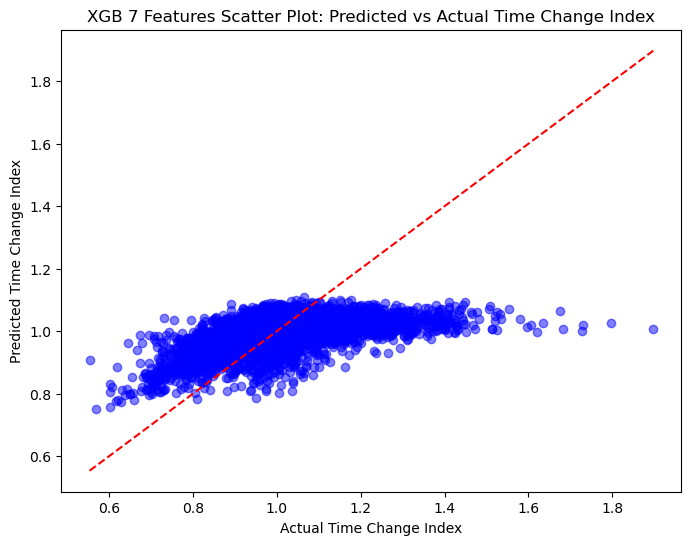

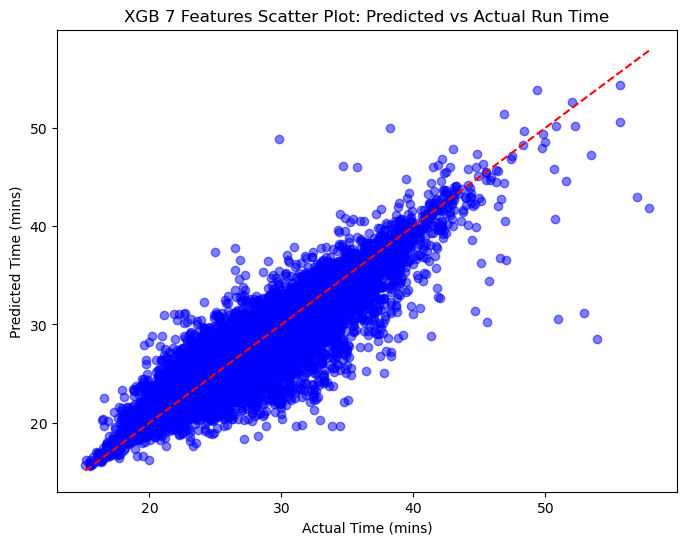

Root Mean Squared Error: 1.596
R-squared: 0.881


array([0.21210666, 0.20317309, 0.1989889 , 0.10398136, 0.06248353,
       0.05763676, 0.04805477, 0.04721106, 0.02354325, 0.02196091,
       0.02085963], dtype=float32)

In [66]:
evaluate_model(best_model7, 7, 'XGB 7 Features', ranked_columns, X_train_norm_df, y_train, X_test_norm_df, y_test)

Training RMSE: 0.060
Training R-squared: 0.234

Test RMSE: 0.060
Test R-squared: 0.217


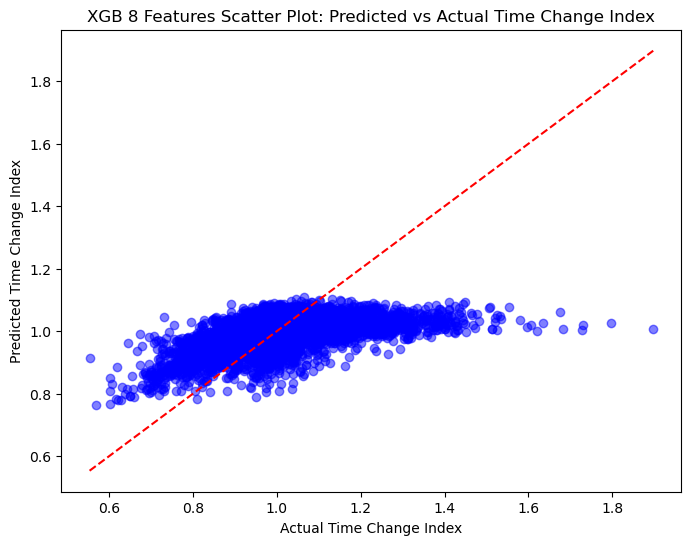

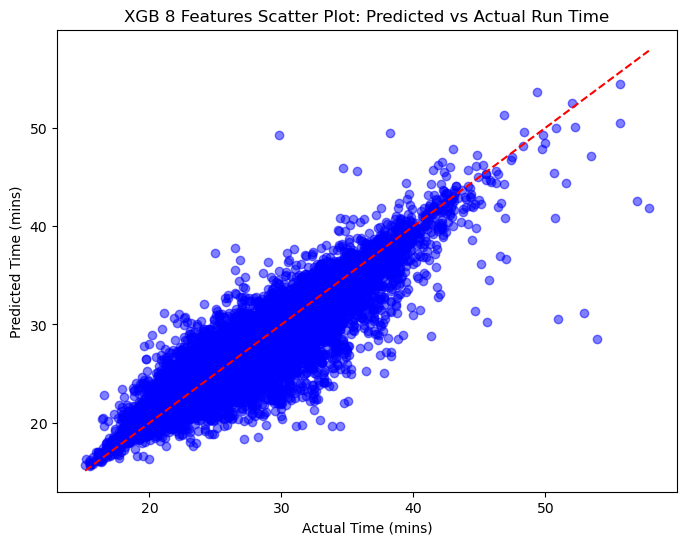

Root Mean Squared Error: 1.594
R-squared: 0.881


array([0.21210666, 0.20317309, 0.1989889 , 0.10398136, 0.06248353,
       0.05763676, 0.04805477, 0.04721106, 0.02354325, 0.02196091,
       0.02085963], dtype=float32)

In [67]:
evaluate_model(best_model8, 8, 'XGB 8 Features', ranked_columns, X_train_norm_df, y_train, X_test_norm_df, y_test)

Training RMSE: 0.060
Training R-squared: 0.235

Test RMSE: 0.060
Test R-squared: 0.221


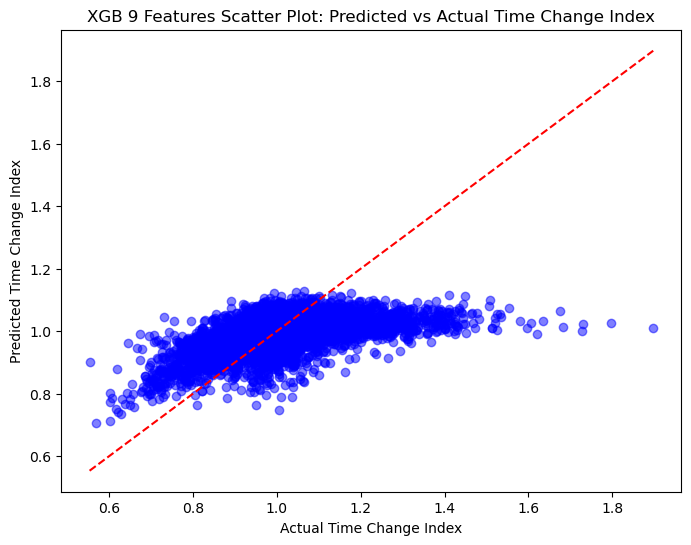

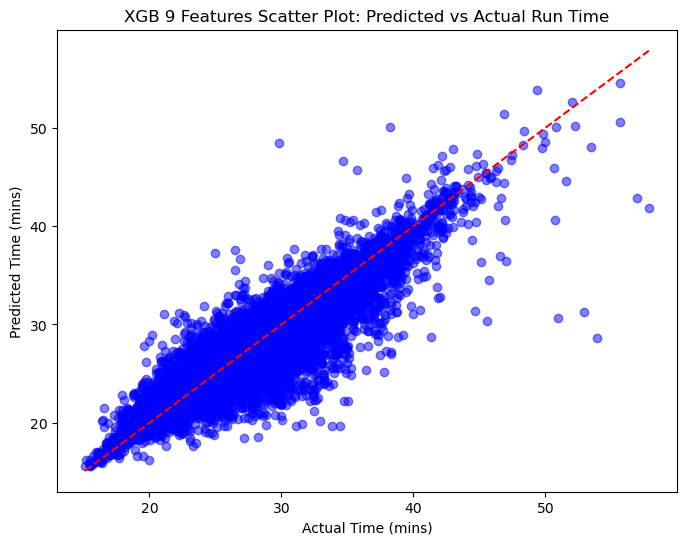

Root Mean Squared Error: 1.59
R-squared: 0.881


array([0.21210666, 0.20317309, 0.1989889 , 0.10398136, 0.06248353,
       0.05763676, 0.04805477, 0.04721106, 0.02354325, 0.02196091,
       0.02085963], dtype=float32)

In [68]:
evaluate_model(best_model9, 9, 'XGB 9 Features', ranked_columns, X_train_norm_df, y_train, X_test_norm_df, y_test)